In [ ]:
import pandas as pd

# load clinical_data.csv
clinical_data = pd.read_csv('clinical_data.csv')

# display
clinical_data.head()

,patient_id,study_id,sex,age,race,histology,smoking_status,stage,survival_months,survival_status,egfr_mutated,kras_mutated,tp53_mutated
0,tcga-44-4112,nsclc_tcga_broad_2016,female,60.0,caucasian,luad,smoker,stage_1,26.564092,1.0,egfr_neg,kras_neg,tp53_neg
1,tcga-44-5644,nsclc_tcga_broad_2016,female,51.0,caucasian,luad,smoker,stage_1,28.372292,0.0,egfr_neg,kras_neg,tp53_pos
2,tcga-44-5645,nsclc_tcga_broad_2016,female,61.0,african_american,luad,smoker,stage_1,28.010652,0.0,egfr_pos,kras_neg,tp53_pos
3,tcga-44-5643,nsclc_tcga_broad_2016,male,53.0,african_american,luad,smoker,stage_3,33.303745,0.0,egfr_neg,kras_neg,tp53_neg
4,tcga-44-6144,nsclc_tcga_broad_2016,male,58.0,caucasian,luad,smoker,stage_1,23.769603,0.0,egfr_neg,kras_pos,tp53_pos


=== Data Analysis Report ===

1. Basic Information:
Total samples: 989

Missing values:
age                35
race               62
smoking_status     18
stage               7
survival_months    34
survival_status     4
dtype: int64

2. Smoking Status Distribution:
smoking_status
smoker        0.53862
non_smoker    0.46138
Name: proportion, dtype: float64


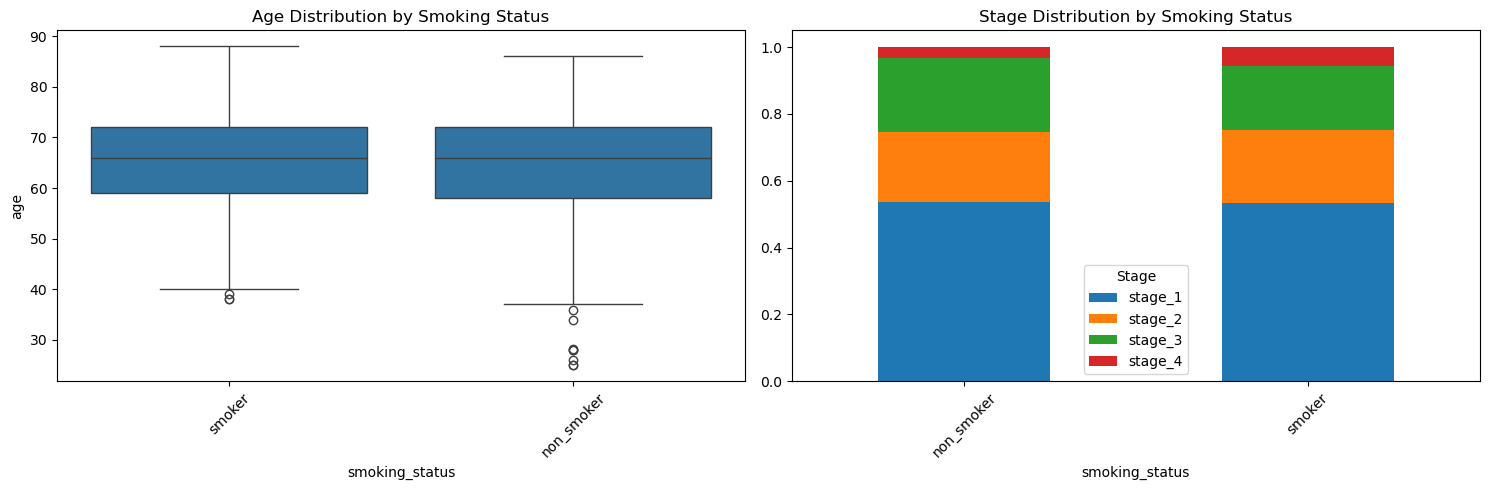

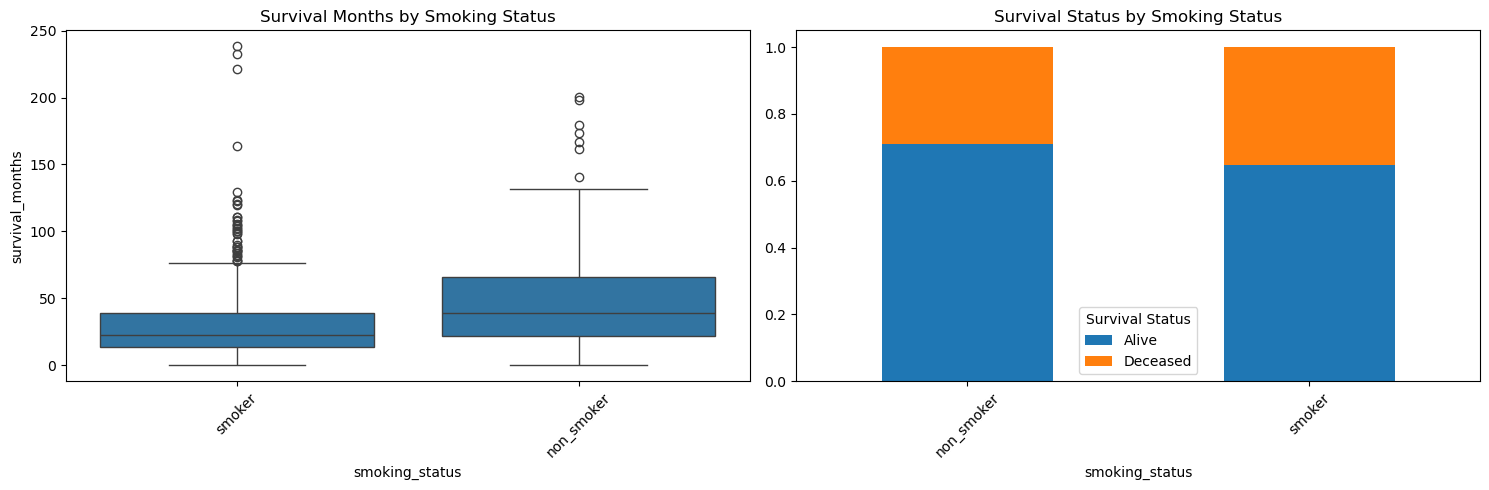

<Figure size 1500x500 with 0 Axes>

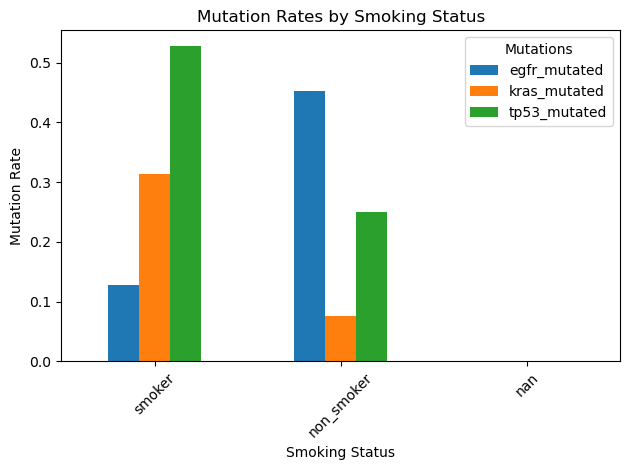

Dropping rows with missing target values.

Data split summary:
Training set size: 788
Test set size: 197
Number of features: 15

Supervised Learning Data Shapes:
X_train: (788, 15)
X_test: (197, 15)

Unsupervised Learning Data Shape:
X: (989, 15)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

class LUADDataPreprocessor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        
        # Define feature groups
        self.id_cols = ['patient_id', 'study_id']
        self.target_cols = ['survival_months', 'survival_status']
        self.numeric_features = ['age']
        self.categorical_features = ['sex', 'race', 'stage', 'smoking_status']
        self.binary_features = ['egfr_mutated', 'kras_mutated', 'tp53_mutated']
        
        # Initialize the preprocessor
        self.preprocessor = None
        self.feature_names = None
        self.encoders = {}
        
    def fit_transform(self, df):
        """Main preprocessing pipeline"""
        # Create a copy and clean data
        data = self._clean_data(df.copy())
        
        # Process each type of feature separately
        numeric_features = self._process_numeric_features(data)
        categorical_features = self._process_categorical_features(data)
        binary_features = self._process_binary_features(data)
        
        # Combine all features
        processed_data = pd.concat([numeric_features, categorical_features, binary_features], axis=1)
        
        # Create smoking interaction terms
        processed_data = self._create_smoking_interactions(processed_data)
        
        return processed_data
    
    def _clean_data(self, df):
        """Initial data cleaning"""
        # Convert binary features
        for col in self.binary_features:
            df[col] = df[col].apply(lambda x: 1 if 'pos' in str(x).lower() else 0)
        
        # Clean categorical features
        for col in self.categorical_features:
            df[col] = df[col].fillna('unknown')
            df[col] = df[col].astype(str).str.lower()
        
        # Clean numeric features
        df[self.numeric_features] = df[self.numeric_features].apply(pd.to_numeric, errors='coerce')
        
        return df
    
    def _process_numeric_features(self, df):
        """Process numeric features"""
        numeric_data = df[self.numeric_features].copy()
        
        # Impute missing values
        imputer = SimpleImputer(strategy='median')
        numeric_data = pd.DataFrame(
            imputer.fit_transform(numeric_data),
            columns=self.numeric_features,
            index=df.index
        )
        
        # Scale features
        scaler = StandardScaler()
        numeric_data = pd.DataFrame(
            scaler.fit_transform(numeric_data),
            columns=self.numeric_features,
            index=df.index
        )
        
        self.encoders['numeric'] = {'imputer': imputer, 'scaler': scaler}
        return numeric_data
    
    def _process_categorical_features(self, df):
        """Process categorical features"""
        categorical_data = df[self.categorical_features].copy()
        
        # One-hot encode each categorical feature
        encoded_features = pd.DataFrame(index=df.index)
        
        for feature in self.categorical_features:
            # Get unique values and sort them
            unique_vals = sorted(df[feature].unique())
            
            # Create one-hot encoder
            encoder = OneHotEncoder(sparse_output=False, drop='first')
            encoded = encoder.fit_transform(df[[feature]])
            
            # Get feature names (excluding the first category)
            feature_names = [f"{feature}_{val}" for val in unique_vals[1:]]
            
            # Create DataFrame with encoded values
            encoded_df = pd.DataFrame(
                encoded,
                columns=feature_names,
                index=df.index
            )
            
            # Store encoder
            self.encoders[feature] = encoder
            
            # Append to result
            encoded_features = pd.concat([encoded_features, encoded_df], axis=1)
        
        return encoded_features
    
    def _process_binary_features(self, df):
        """Process binary features"""
        return df[self.binary_features].copy()
    
    def _create_smoking_interactions(self, df):
        """Create interaction terms with smoking status"""
        # Get smoking status indicator columns
        smoking_cols = [col for col in df.columns if 'smoking_status_' in col]
        if not smoking_cols:
            return df
        
        # Use non-smoker status for interactions
        non_smoker_col = [col for col in smoking_cols if 'non_smoker' in col]
        if not non_smoker_col:
            return df
        
        non_smoker_status = df[non_smoker_col[0]]
        
        # Features to create interactions with
        interaction_features = (
            self.numeric_features +
            [col for col in df.columns if 'stage_' in col] +
            self.binary_features
        )
        
        # Create interactions
        interactions_df = pd.DataFrame(index=df.index)
        for feature in interaction_features:
            if feature in df.columns:
                interactions_df[f'{feature}_smoking_interaction'] = df[feature] * non_smoker_status
        
        return pd.concat([df, interactions_df], axis=1)
    
    def prepare_supervised_learning(self, df, target='survival_status', test_size=0.2):
        """Prepare data for supervised learning"""
        # Transform features
        X = self.fit_transform(df)
        
        # Handle target variable
        if df[target].isnull().any():
            print(f"Warning: Found {df[target].isnull().sum()} missing values in target variable.")
            print("Dropping rows with missing target values.")
            valid_idx = df[target].notnull()
            X = X[valid_idx]
            df = df[valid_idx]
        
        y = df[target].values
        
        # Create stratification variable (handle NaN values)
        stratify_var = df['smoking_status'].fillna('unknown')
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=test_size, 
            random_state=self.random_state,
            stratify=stratify_var
        )
        
        print(f"\nData split summary:")
        print(f"Training set size: {len(X_train)}")
        print(f"Test set size: {len(X_test)}")
        print(f"Number of features: {X_train.shape[1]}")
        
        return X_train, X_test, y_train, y_test
    
    def prepare_unsupervised_learning(self, df):
        """Prepare data for unsupervised learning"""
        # Transform features without interactions
        X = self.fit_transform(df)
        
        # Create metadata for interpretation
        metadata = df[self.id_cols + self.target_cols + ['smoking_status']].copy()
        
        return X, metadata
    
    def analyze_data(self, df):
        """Perform exploratory data analysis"""
        print("=== Data Analysis Report ===")
        
        # Basic information
        print("\n1. Basic Information:")
        print(f"Total samples: {len(df)}")
        print("\nMissing values:")
        print(df.isnull().sum()[df.isnull().sum() > 0])
        
        # Smoking status distribution
        print("\n2. Smoking Status Distribution:")
        smoking_dist = df['smoking_status'].value_counts(normalize=True)
        print(smoking_dist)
        
        # Create visualizations
        self._plot_distributions(df)
        self._plot_survival_analysis(df)
        self._plot_mutation_patterns(df)
    
    def _plot_distributions(self, df):
        """Plot feature distributions"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Age distribution by smoking status
        sns.boxplot(x='smoking_status', y='age', data=df, ax=ax1)
        ax1.set_title('Age Distribution by Smoking Status')
        ax1.tick_params(axis='x', rotation=45)
        
        # Stage distribution by smoking status
        stage_data = pd.crosstab(df['smoking_status'], df['stage'], normalize='index')
        stage_data.plot(kind='bar', stacked=True, ax=ax2)
        ax2.set_title('Stage Distribution by Smoking Status')
        ax2.tick_params(axis='x', rotation=45)
        ax2.legend(title='Stage')
        
        plt.tight_layout()
        plt.show()
    
    def _plot_survival_analysis(self, df):
        """Plot survival-related visualizations"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Survival months distribution
        sns.boxplot(x='smoking_status', y='survival_months', data=df, ax=ax1)
        ax1.set_title('Survival Months by Smoking Status')
        ax1.tick_params(axis='x', rotation=45)
        
        # Survival status proportion
        survival_data = pd.crosstab(
            df['smoking_status'], 
            df['survival_status'],
            normalize='index'
        )
        survival_data.plot(kind='bar', stacked=True, ax=ax2)
        ax2.set_title('Survival Status by Smoking Status')
        ax2.tick_params(axis='x', rotation=45)
        ax2.legend(title='Survival Status', labels=['Alive', 'Deceased'])
        
        plt.tight_layout()
        plt.show()
    
    def _plot_mutation_patterns(self, df):
        """Plot mutation patterns"""
        plt.figure(figsize=(15, 5))
        
        # Convert mutations to numeric format for plotting
        df_mut = df.copy()
        for col in self.binary_features:
            df_mut[col] = df_mut[col].apply(lambda x: 1 if 'pos' in str(x).lower() else 0)
        
        # Calculate mutation rates by smoking status
        mutation_rates = pd.DataFrame(index=df_mut['smoking_status'].unique())
        
        for mutation in self.binary_features:
            rates = df_mut.groupby('smoking_status')[mutation].mean()
            mutation_rates[mutation] = rates
        
        # Plot mutation rates
        mutation_rates.plot(kind='bar')
        plt.title('Mutation Rates by Smoking Status')
        plt.ylabel('Mutation Rate')
        plt.xlabel('Smoking Status')
        plt.xticks(rotation=45)
        plt.legend(title='Mutations')
        
        plt.tight_layout()
        plt.show()

# Usage example:
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('clinical_data.csv')
    
    # Initialize preprocessor
    preprocessor = LUADDataPreprocessor()
    
    # Analyze raw data
    preprocessor.analyze_data(df)
    
    # Prepare data for supervised learning
    X_train, X_test, y_train, y_test = preprocessor.prepare_supervised_learning(df)
    print("\nSupervised Learning Data Shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    
    # Prepare data for unsupervised learning
    X_unsup, metadata = preprocessor.prepare_unsupervised_learning(df)
    print("\nUnsupervised Learning Data Shape:")
    print(f"X: {X_unsup.shape}")

    # Save files
    # np.save('X_train.npy', X_train)
    # np.save('X_test.npy', X_test)
    # np.save('y_train.npy', y_train)
    # np.save('y_test.npy', y_test)
    # np.save('X_unsup.npy', X_unsup)
    # metadata.to_csv('metadata.csv', index=False)

## Dataset Overview:

Total samples: 989 patients\

Missing data present across several variables:

Age: 35 missing (3.5%)

Race: 62 missing (6.3%)

Smoking status: 18 missing (1.8%)

Stage: 7 missing (0.7%)

Survival months: 34 missing (3.4%)

Survival status: 4 missing (0.4%)




#### Smoking Status Distribution:


Nearly balanced dataset:

Smokers: 53.9%

Non-smokers: 46.1%

This balance is beneficial for our analysis as it reduces potential bias.




#### Age Distribution by Smoking Status:


* Median age is similar between smokers and non-smokers (around 65-70 years)
* Both groups show similar age ranges (approximately 40-80 years)
* Some outliers present in both groups, particularly younger patients
* Non-smokers show slightly more age variability with a few very young outliers (25-30 years)


#### Disease Stage Distribution:

Stage distribution is similar between smokers and non-smokers
* Stage 1 is most common (approximately 50%) in both groups
* Stage 2 and 3 make up most of the remaining cases
* Stage 4 represents the smallest proportion in both groups
* No major differences in stage distribution between smokers and non-smokers


#### Survival Analysis:


Survival Months:

* Non-smokers show higher median survival time
* Non-smokers have wider interquartile range in survival months
* Both groups have outliers with very long survival times (>150 months)
* Smokers show more concentrated distribution of survival times


#### Survival Status (0=alive, 1=deceased):

* Both groups show similar survival status distributions
* Approximately 65-70% survival rate in both groups
* Slightly better survival rate in non-smokers




#### Mutation Patterns:

Clear differences in mutation patterns between smokers and non-smokers:

* EGFR mutations: Much more common in non-smokers (~45% vs ~12%)
* KRAS mutations: More common in smokers (~31% vs ~8%)
* TP53 mutations: More common in smokers (~52% vs ~25%)




## Data Processing Results:

Final dataset for modeling:

* Training set: 788 samples (80%)
* Test set: 197 samples (20%)
* 15 features after preprocessing